In [ ]:
import marimo as mo
import numpy as np
import matplotlib.pyplot as plt
import ellphi
import time
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import os
from numpy.linalg import inv, norm

# Configure matplotlib for publication quality
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'serif'

# Ensure output directories exist
import os
os.makedirs("experiments/apct_2025/validation/figs", exist_ok=True)
os.makedirs("experiments/apct_2025/validation/data", exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

mo.md("# Task 1: Computational & Mathematical Validation")

/Users/uda/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/ny/fq4xdlhd7k5c6q8w_cz3l1rw0000gn/T/matplotlib-1han44ar because there was an issue with the default path (/Users/uda/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [ ]:
def generate_random_ellipsoid(dim):
    """Generates a random ellipsoid defined by mean and covariance."""
    mean = np.random.randn(dim)
    # Generate random covariance matrix
    A = np.random.randn(dim, dim)
    cov = A @ A.T + np.eye(dim) * 0.1 # Ensure positive definite
    return mean, cov

In [ ]:
mo.md(
    r"""
    ## Subtask 1.1: Scalability Benchmark

    **Objective**: Quantify the computational cost of the tangency solver as a function of dimension $n$ and verify the performance gain of the C++ backend.

    **Methodology**:
    - **Dimensions**: $n \in \{2, 3, 5, 10, 20, 50, 100\}$
    - **Sample Size**: 1,000 random ellipsoid pairs per dimension.
    - **Backends**: Comparison between Pure Python and C++ Extension (if available).
    """
)

def run_benchmark():
    dims = [2, 3, 5, 10, 20, 50, 100]
    n_samples = 1000
    results = []

    backends = ['python']
    if ellphi.has_cpp_backend():
        backends.append('cpp') # Assuming 'cpp' or 'auto' maps to C++ if available

    for dim in tqdm(dims, desc="Benchmarking dimensions"):
        # Pre-generate data to just measure solver time
        pairs = []
        for _ in range(n_samples):
            m1, c1 = generate_random_ellipsoid(dim)
            m2, c2 = generate_random_ellipsoid(dim)
            pcoef = ellphi.coef_from_cov(m1, c1)
            qcoef = ellphi.coef_from_cov(m2, c2)
            pairs.append((pcoef, qcoef))

        for backend in backends:
            start_time = time.time()
            for pcoef, qcoef in pairs:
                ellphi.tangency(pcoef, qcoef, backend=backend)
            end_time = time.time()
            avg_time_ms = (end_time - start_time) / n_samples * 1000
            results.append({
                "Dimension": dim,
                "Backend": backend,
                "Time (ms)": avg_time_ms
            })

    return pd.DataFrame(results)

# Run benchmark if not just viewing
# In marimo, cells run automatically.
# We can use a button to trigger re-run if needed, but for now just run.
df_benchmark = run_benchmark()

# Save data
df_benchmark.to_csv("experiments/apct_2025/validation/data/scaling_benchmark.csv", index=False)

Benchmarking dimensions: 100%|██████████████████████████████████| 7/7 [00:13<00:00,  1.91s/it]


In [ ]:
# Plotting Subtask 1.1
fig1, ax1 = plt.subplots(figsize=(6, 4))

# Check if we have multiple backends
for backend, group in df_benchmark.groupby("Backend"):
    ax1.loglog(group["Dimension"], group["Time (ms)"], marker='o', label=f"Backend: {backend}")

ax1.set_xlabel("Dimension ($n$)")
ax1.set_ylabel("Time per Check (ms)")
ax1.set_title("Scalability Benchmark: Ellipsoid Tangency")
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend()

plt.tight_layout()
plt.savefig("experiments/apct_2025/validation/figs/scaling_benchmark.pdf")

### Benchmark Results
Saved to `experiments/apct_2025/validation/figs/scaling_benchmark.pdf`

<marimo-mime-renderer data-mime='&quot;application/vnd.marimo+mimebundle&quot;' data-data='&quot;{&#92;&quot;image/png&#92;&quot;: &#92;&quot;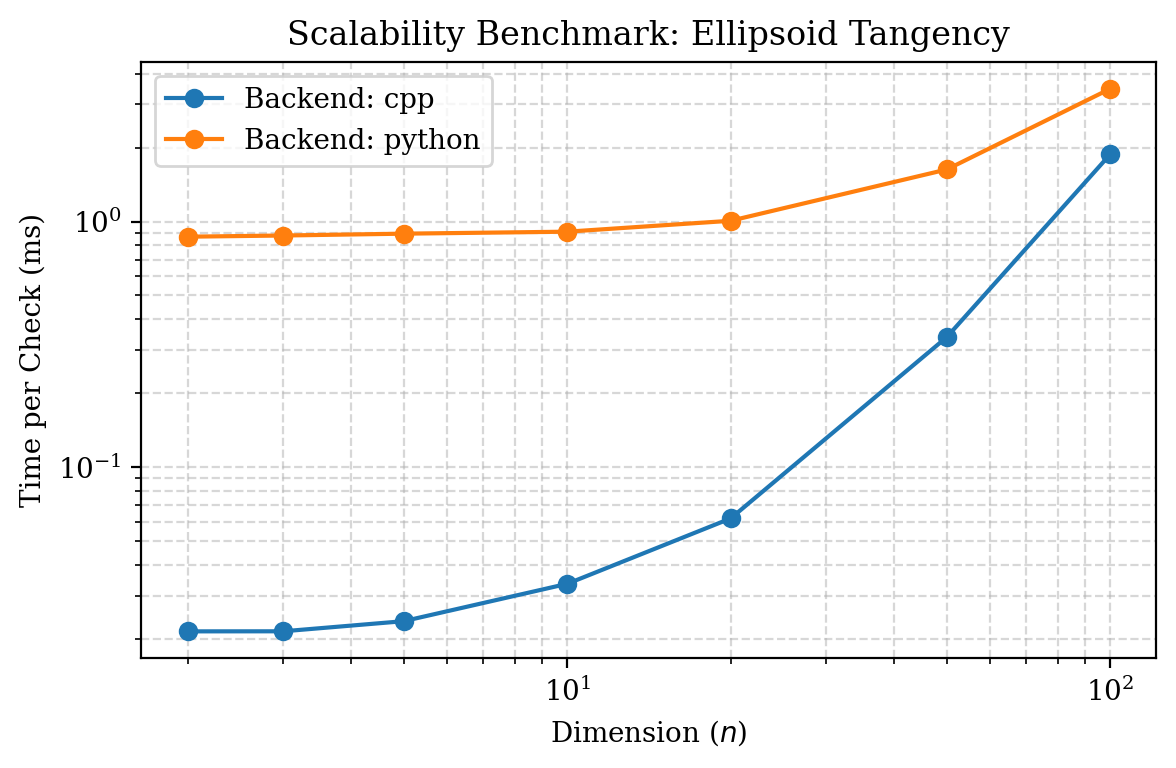&#92;&quot;, &#92;&quot;__metadata__&#92;&quot;: {&#92;&quot;image/png&#92;&quot;: {&#92;&quot;width&#92;&quot;: 588, &#92;&quot;height&#92;&quot;: 384}}}&quot;'></marimo-mime-renderer>

In [ ]:
mo.md(f"""
### Benchmark Results
Saved to `experiments/apct_2025/validation/figs/scaling_benchmark.pdf`

{mo.as_html(fig1)}
""")

## Subtask 1.2: Gradient Correctness (Finite Difference Check)

**Objective**: Empirically prove the differentiability of the contact time $t$. The analytical gradient must match the numerical gradient to high precision. This validates the "Trust Layer" required for gradient-based optimization.

**Methodology**:
- **Procedure**: Compare **Analytical Gradient** $\nabla_{\text{ana}}$ (derived from Implicit Function Theorem) vs. **Numerical Gradient** $\nabla_{\text{num}}$ (Central Finite Difference).
- **Perturbation**: $\epsilon = 10^{-6}$
- **Success Criterion**: Relative Error $\frac{\|\nabla_{\text{ana}} - \nabla_{\text{num}}\|_F}{\|\nabla_{\text{ana}}\|_F} < 10^{-5}$.

In [ ]:
def compute_analytical_gradient(m1, c1, m2, c2, t, point):
    """
    Computes analytical gradient of t w.r.t m2 (center of second ellipsoid).

    Uses the implicit function theorem on the tangency condition:
    n1 + lambda * n2 = 0
    """
    C1_inv = inv(c1)
    C2_inv = inv(c2)

    n1 = C1_inv @ (point - m1)
    n2 = C2_inv @ (point - m2)

    # Calculate lambda
    norm_n1 = norm(n1)
    norm_n2 = norm(n2)

    # Avoid division by zero
    if norm_n2 < 1e-12:
        return np.zeros_like(m2)

    lamb = norm_n1 / norm_n2



    grad = - n2 / (t * (1.0 + 1.0/lamb))

    return grad

def tangency_time_func(m_variable, c_variable, m_fixed, c_fixed):
    pcoef = ellphi.coef_from_cov(m_fixed, c_fixed)
    qcoef = ellphi.coef_from_cov(m_variable, c_variable)
    res = ellphi.tangency(pcoef, qcoef)
    return res.t

In [ ]:
def verify_gradients():
    dims = [2, 5, 10, 20, 50]
    epsilon = 1e-6
    results = []

    # For scatter plot
    scatter_data = {'num': [], 'ana': []}

    for dim in tqdm(dims, desc="Verifying Gradients"):
        # Use 10 samples per dimension for statistics
        for _ in range(10): 
            m1, c1 = generate_random_ellipsoid(dim)
            m2, c2 = generate_random_ellipsoid(dim)

            # Base computation
            pcoef = ellphi.coef_from_cov(m1, c1)
            qcoef = ellphi.coef_from_cov(m2, c2)
            res = ellphi.tangency(pcoef, qcoef)
            t_base = res.t
            point = res.point

            # Analytical Gradient
            grad_ana = compute_analytical_gradient(m1, c1, m2, c2, t_base, point)

            # Numerical Gradient (Finite Difference on m2)
            grad_num = np.zeros(dim)
            for i in range(dim):
                m2_plus = m2.copy()
                m2_plus[i] += epsilon
                t_plus = tangency_time_func(m2_plus, c2, m1, c1)

                m2_minus = m2.copy()
                m2_minus[i] -= epsilon
                t_minus = tangency_time_func(m2_minus, c2, m1, c1)

                grad_num[i] = (t_plus - t_minus) / (2 * epsilon)

            # Compare
            # Relative Error: ||ana - num|| / ||ana||
            diff_norm = norm(grad_ana - grad_num)
            ana_norm = norm(grad_ana)

            if ana_norm < 1e-12:
                rel_error = 0.0 # Should not happen with random ellipsoids
            else:
                rel_error = diff_norm / ana_norm

            results.append({
                "Dimension": dim,
                "Relative Error": rel_error,
                "Log10 Error": np.log10(rel_error + 1e-20)
            })

            scatter_data['num'].extend(grad_num.tolist())
            scatter_data['ana'].extend(grad_ana.tolist())

    return pd.DataFrame(results), pd.DataFrame(scatter_data)

df_grads, df_scatter = verify_gradients()

# Save results
df_grads.to_csv("experiments/apct_2025/validation/data/gradient_verification.csv", index=False)

# Plot Box Plot
fig2, ax2 = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df_grads, x="Dimension", y="Log10 Error", ax=ax2)
ax2.axhline(np.log10(1e-5), color='r', linestyle='--', label='Threshold ($10^{-5}$)')
ax2.set_title("Gradient Verification: Relative Error Distribution")
ax2.legend()
plt.tight_layout()
plt.savefig("experiments/apct_2025/validation/figs/gradient_verification.pdf")

# Plot Scatter
fig3, ax3 = plt.subplots(figsize=(5, 5))
# Subsample scatter if too large
sub_scatter = df_scatter.sample(n=min(1000, len(df_scatter))) if len(df_scatter) > 1000 else df_scatter
ax3.scatter(sub_scatter['num'], sub_scatter['ana'], alpha=0.5, s=10)

# Diagonal line
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]
ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax3.set_xlabel("Numerical Gradient")
ax3.set_ylabel("Analytical Gradient")
ax3.set_title("Gradient Alignment")
plt.tight_layout()
plt.savefig("experiments/apct_2025/validation/figs/gradient_scatter.png")

Verifying Gradients: 100%|██████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


### Gradient Verification Results
Saved plots to `experiments/apct_2025/validation/figs/`

<div style='display: flex;flex: 1;flex-direction: row;justify-content: flex-start;align-items: normal;flex-wrap: nowrap;gap: 0.5rem'><marimo-mime-renderer data-mime='&quot;application/vnd.marimo+mimebundle&quot;' data-data='&quot;{&#92;&quot;image/png&#92;&quot;: &#92;&quot;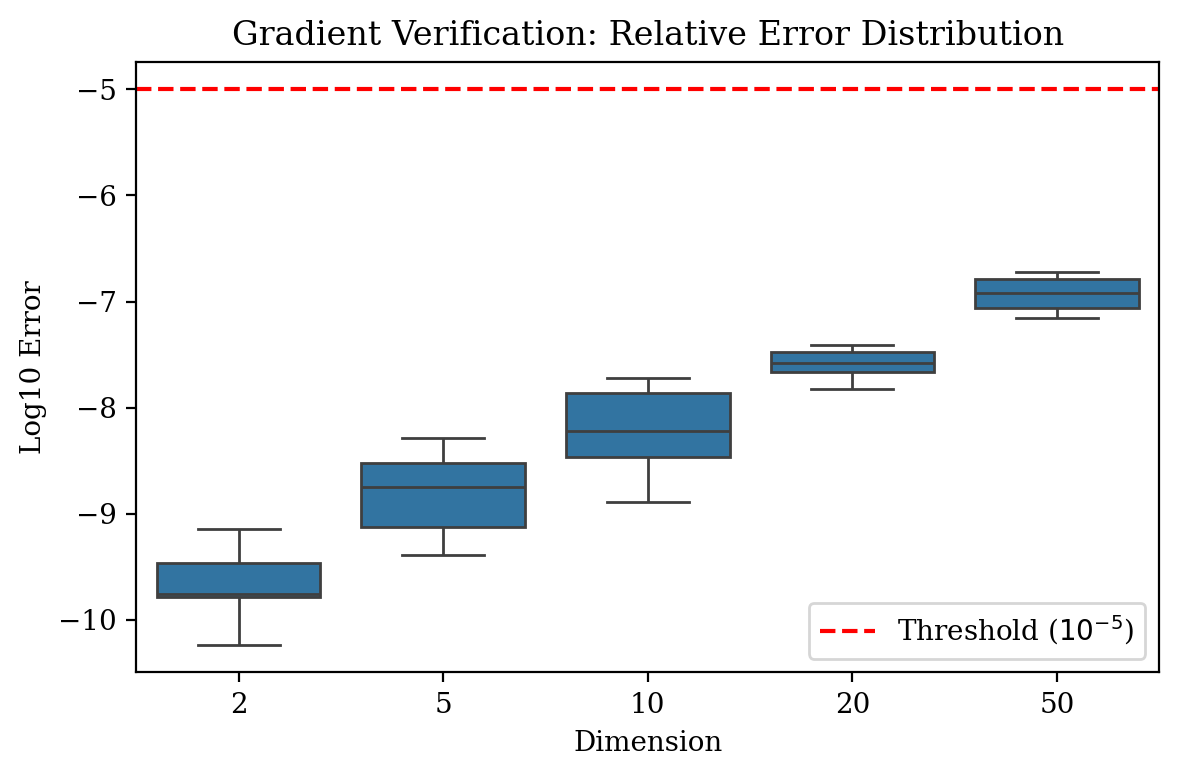&#92;&quot;, &#92;&quot;__metadata__&#92;&quot;: {&#92;&quot;image/png&#92;&quot;: {&#92;&quot;width&#92;&quot;: 589, &#92;&quot;height&#92;&quot;: 388}}}&quot;'></marimo-mime-renderer><marimo-mime-renderer data-mime='&quot;application/vnd.marimo+mimebundle&quot;' data-data='&quot;{&#92;&quot;image/png&#92;&quot;: &#92;&quot;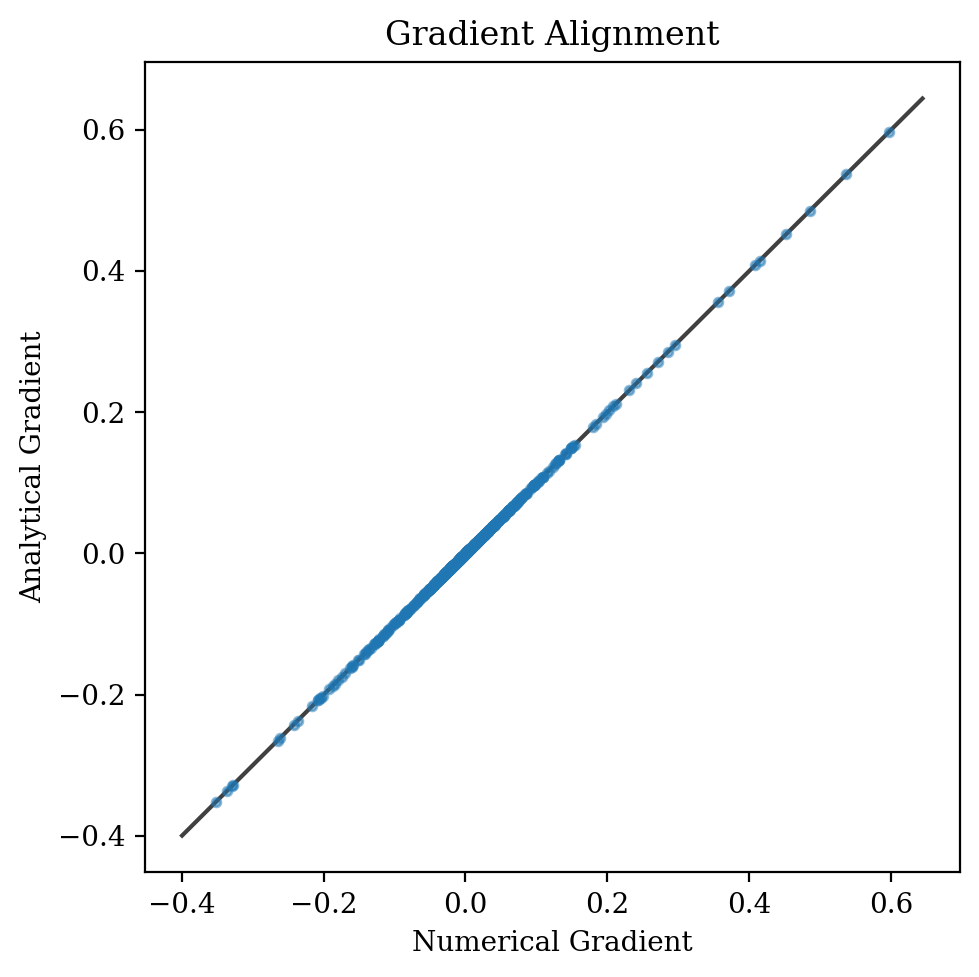&#92;&quot;, &#92;&quot;__metadata__&#92;&quot;: {&#92;&quot;image/png&#92;&quot;: {&#92;&quot;width&#92;&quot;: 489, &#92;&quot;height&#92;&quot;: 488}}}&quot;'></marimo-mime-renderer></div>

In [ ]:
mo.md(f"""
### Gradient Verification Results
Saved plots to `experiments/apct_2025/validation/figs/`

{mo.hstack([fig2, fig3], justify="start")}
""")